# Experiment 1

This experiment is the same as experiment 1 for regression, i.e. we are trying to predict the next frame given the previous one. We will also see if predicting using more frames in the past yields better results.

In [2]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

# import functions
import sys
sys.path.insert(0, '../')
from my_functions import *

from sklearn import preprocessing

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
# this function splits the data in sequences
# each sequence is n_steps long and outputs a single value, i.e. the next time frame
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

## Read data

In [4]:
data = pd.read_csv('../../data/processed/trajectories.csv')

# first, scale the data x and y separately as they have very different ranges

min_max_scaler_x = preprocessing.MinMaxScaler()
min_max_scaler_y = preprocessing.MinMaxScaler()

data_scaled = data.copy()

data_scaled['x'] = min_max_scaler_x.fit_transform(np.reshape(data['x'].values.astype(float), (-1, 1)))
data_scaled['y'] = min_max_scaler_y.fit_transform(np.reshape(data['y'].values.astype(float), (-1, 1)))

data_scaled.head()

,y,x,frame,particle
0,0.065298,0.003366,0.0,0.0
1,0.105854,0.008537,0.0,1.0
2,0.220930,0.001087,0.0,2.0
3,0.274271,0.005597,0.0,3.0
4,0.277575,0.010755,0.0,4.0


**Particles used for training**


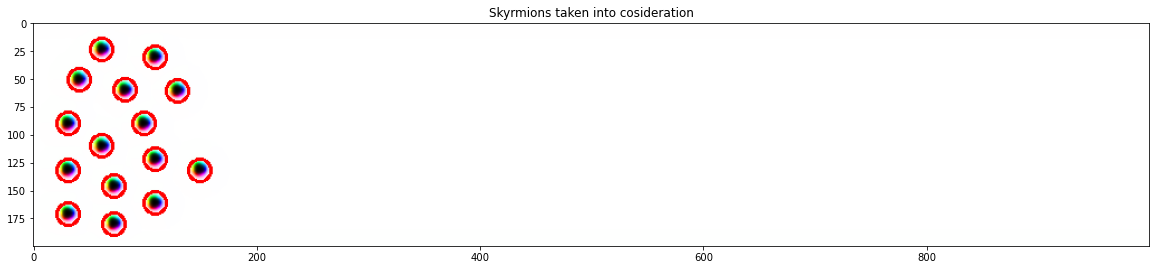

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 122.88it/s]


In [5]:
# show which frames we will be working on
print('**Particles used for training**')
show_tracked(data, '../../data/raw')

# format data so that it is in the format (frame, next_frame)
frames = np.array(get_frames(data_scaled))

In [6]:
# split into train and test sets
# we will use one third for testing
train_size = int(len(frames) * 0.67)
test_size = len(frames) - train_size
train, test = frames[0:train_size,:], frames[train_size:len(frames),:]
print(f'Train length: {len(train)}')
print(f'Test length: {len(test)}')

Train length: 536
Test length: 264


In [7]:
# choose a number of time steps
n_steps = 1

# convert into input/output
X_train, y_train = split_sequences(train, n_steps)
X_test, y_test = split_sequences(test, n_steps)

# the dataset knows the number of features
n_features = X_train.shape[2]

## Define the model and train

In [8]:
# define model
def create_model():
    model = Sequential()
    
    model.add(SimpleRNN(64, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(n_features))
    
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [9]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = '../../models/rnn_1/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0, 
    save_weights_only=True,
    period=5)

In [10]:
# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
history = model.fit(
    X_train, 
    y_train,
    epochs=1000, 
    callbacks=[cp_callback],
    validation_data=(X_test,y_test))

Train on 535 samples, validate on 263 samples
Epoch 1/1000
535/535 [==============================] - 0s 575us/step - loss: 0.2327 - val_loss: 0.2485
Epoch 2/1000
535/535 [==============================] - 0s 47us/step - loss: 0.0751 - val_loss: 0.1214
Epoch 3/1000
535/535 [==============================] - 0s 48us/step - loss: 0.0270 - val_loss: 0.1175
Epoch 4/1000
535/535 [==============================] - 0s 54us/step - loss: 0.0175 - val_loss: 0.0976
Epoch 5/1000
535/535 [==============================] - 0s 50us/step - loss: 0.0141 - val_loss: 0.0803
Epoch 6/1000
535/535 [==============================] - 0s 49us/step - loss: 0.0116 - val_loss: 0.0669
Epoch 7/1000
535/535 [==============================] - 0s 52us/step - loss: 0.0094 - val_loss: 0.0511
Epoch 8/1000
535/535 [==============================] - 0s 47us/step - loss: 0.0077 - val_loss: 0.0428
Epoch 9/1000
535/535 [==============================] - 0s 52us/step - loss: 0.0063 - val_loss: 0.0373
Epoch 10/1000
535/535 [===

## Evaluate

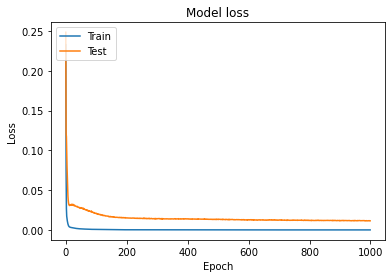

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [12]:
print('The model performance for X_train')
pred_train = evaluate(X_train, y_train, model)
print('The model performance for X_test')
pred_test = evaluate(X_test, y_test, model)

The model performance for X_train
--------------------------------------
RMSE is 0.013618983312161879
R2 score is 0.9746851412954292


The model performance for X_test
--------------------------------------
RMSE is 0.10771851623641053
R2 score is -1.3011348667740321




In [13]:
pred_train_df = get_predictions_df(pred_train)
pred_test_df = get_predictions_df(pred_test)

Prediction to dataframe: 100%|█████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:04<00:00, 58.23it/s]


In [14]:
pred_train_unscaled = pred_train_df.copy()
pred_test_unscaled = pred_test_df.copy()

pred_train_unscaled['x'] = min_max_scaler_x.inverse_transform(np.reshape(pred_train_unscaled['x'].values.astype(float), (-1, 1)))
pred_train_unscaled['y'] = min_max_scaler_y.inverse_transform(np.reshape(pred_train_unscaled['y'].values.astype(float), (-1, 1)))

pred_test_unscaled['x'] = min_max_scaler_x.inverse_transform(np.reshape(pred_test_unscaled['x'].values.astype(float), (-1, 1)))
pred_test_unscaled['y'] = min_max_scaler_y.inverse_transform(np.reshape(pred_test_unscaled['y'].values.astype(float), (-1, 1)))

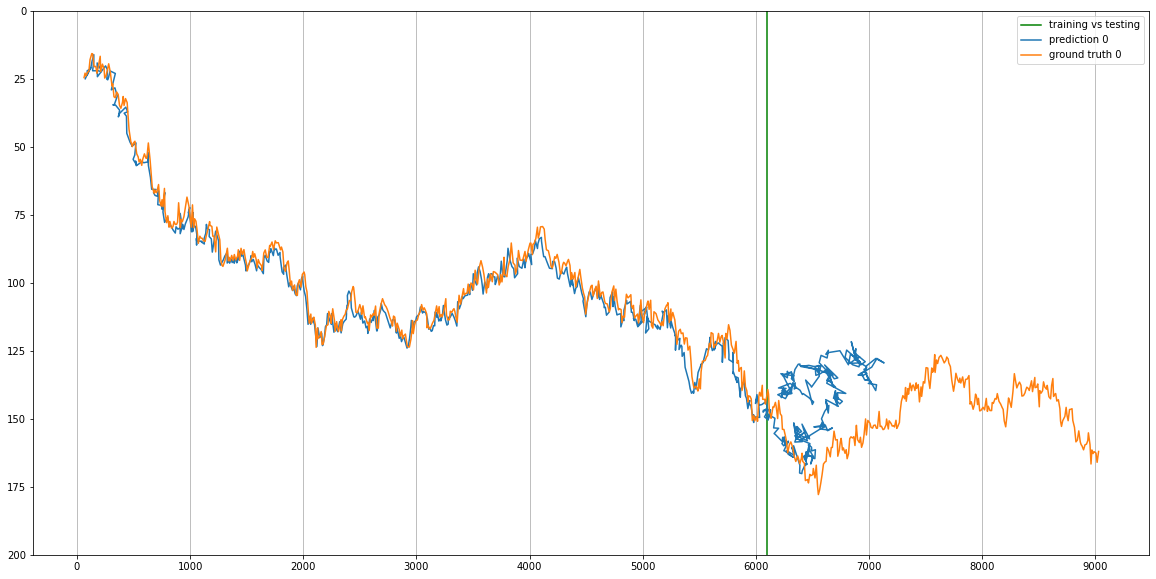

In [15]:
plot_prediction(data, pred_test_unscaled, pred_train_unscaled, ids=[0])

In [16]:
model.save('../../models/rnn_1.h5') 

## Observations

So far, this experiment seems not to yield very good results. This could be likely due to the fact that we are trying to use all the positions in the previous frames to predcit all the future positions and the network might not be learning a complex enough functions to model this behaviour (in particular the interaction and non-interactions between close skyrmions).

Anohter reason as to why this experiment is not yielding good results could be how the data is formatted. Maybe this is not the best way of treating the data.

UPDATE: After running the model for more itarations, we can see that it fits the training data very well, but it is overfitting. We can try to regularize and check the resutls again.